# Loading libraries and functions

In [1]:
# Install required libraries
# %%capture
!pip install neurodsp
!pip install emd
!pip install tslearn
!pip install dtaidistance
!pip install sails
!pip install umap-learn

  Using cached sails-1.6.0-py3-none-any.whl.metadata (3.9 kB)
   ---------------------------------------- 0.0/103.4 kB ? eta -:--:--
   --- ------------------------------------ 10.2/103.4 kB ? eta -:--:--
   ----------- ---------------------------- 30.7/103.4 kB 1.4 MB/s eta 0:00:01
   -------------------------------------  102.4/103.4 kB 991.0 kB/s eta 0:00:01
   ---------------------------------------- 103.4/103.4 kB 1.0 MB/s eta 0:00:00
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 7.0.1
    Uninstalling importlib-metadata-7.0.1:
      Successfully uninstalled importlib-metadata-7.0.1


   ---------------------------------------- 0.0/85.7 kB ? eta -:--:--
   ---- ----------------------------------- 10.2/85.7 kB ? eta -:--:--
   ---------------------------------------- 85.7/85.7 kB 1.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/56.9 kB ? eta -:--:--
   ---------------------------------------- 56.9/56.9 kB 3.1 MB/s eta 0:00:00


In [2]:
# Load required libraries
import numpy as np
from scipy.io import loadmat
from scipy.signal import hilbert
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
from neurodsp.filt import filter_signal, filter_signal_fir, design_fir_filter
import emd
import pandas as pd
from sklearn.preprocessing import Normalizer
from tqdm import tqdm
import plotly.express as px
from tslearn.clustering import TimeSeriesKMeans, KShape
from tslearn.metrics import dtw
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler
import copy
import sails
import umap.umap_ as umap

# Import custom functions
from functions import *

sns.set(style='white', context='notebook')

# Load data

In [3]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [7]:
# Loading sleep scoring data from MAT files stored in Google Drive.
# path_to_data = '/content/drive/My Drive/Donders Internship/2018-07-26_14-20-46_Post-Trial5/'
# data_file = 'PFClfpCleaned.mat'
# states_file = '2018-07-26_14-20-46_Post-Trial5-states.mat'

path_to_data = "./2018-07-26_14-20-46_Post-Trial5/"
data_file = 'PFClfpCleaned.mat'
states_file = '2018-07-26_14-20-46_Post-Trial5-states.mat'
pfc_data, sleep_scoring = load_mat_data(path_to_data, data_file, states_file)

nrem_epochs = np.array(get_all_NREM_epochs(sleep_scoring))

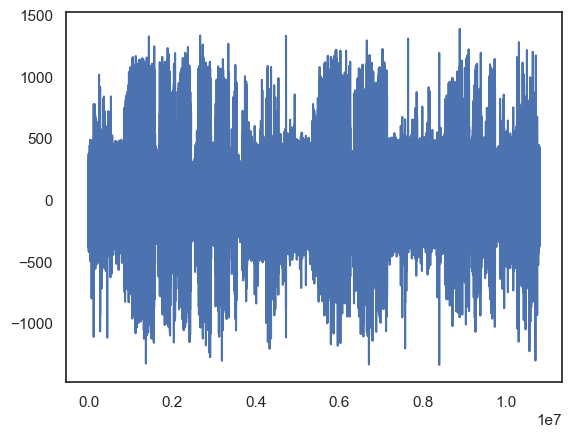

In [8]:
plt.plot(pfc_data);

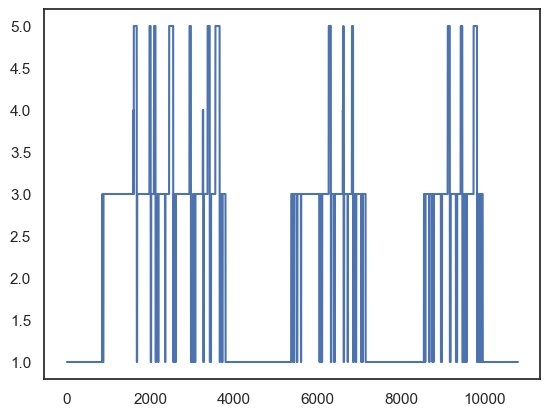

In [9]:
plt.plot(sleep_scoring);

In [10]:
# Samping frequency
len(pfc_data)/len(sleep_scoring)

1000.0773076566985

# Get All Cycles

In [11]:
# Set sampling frequency
fs = 1000

In [12]:
# Get filtered NREM LFP data
nrem_filtered_data, nrem_data = get_nrem_filtered(pfc_data, nrem_epochs, fs=fs)

C:\anaconda3\Lib\site-packages\neurodsp\filt\utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))


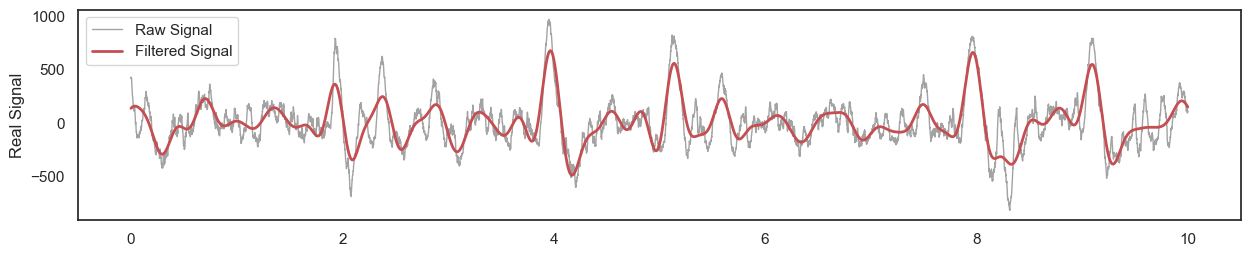

In [13]:
# Plot NREM filtered data (10 sec window)

start = fs*200 # Start position for signal
length = 10

t = np.arange(fs*length) / fs
plt.figure(figsize=(15,6))
plt.subplot(2,1,1)
plt.plot(t,nrem_data[start:start+fs*length], 'k', label='Raw Signal', alpha=0.4, lw=1)
plt.plot(t,nrem_filtered_data[start:start+fs*length], 'r', label='Filtered Signal', lw=2)
plt.ylabel('Real Signal')
plt.legend()

In [14]:
# Get cycles using IP
IP, IF, IA = emd.spectra.frequency_transform(nrem_filtered_data, 1000, 'hilbert')

C = emd.cycles.Cycles(IP)

 Checking Cycles inputs - trimming singleton from input 'IP'


In [15]:
cycles = get_cycles_with_metrics(C, nrem_filtered_data, IA, IF)

In [16]:
# Define thresholds to filter food cycles and subset them
metrics = cycles.get_metric_dataframe()
peak_thresh = np.percentile(metrics['peak_values'], 85)
trough_thresh = np.percentile(metrics['trough_values'], 40)
delta_peak_thresh = np.percentile(metrics['peak_values'], 40)

lo_freq_duration = fs/0.1
hi_freq_duration = fs/4

In [17]:
# Apply conditions to get good cycles
conditions = ['is_good==1',
              # f'max_amp>{amp_thresh}',
              f'duration_samples<{lo_freq_duration}',
              f'duration_samples>{hi_freq_duration}',
              # f'peak_values>={peak_thresh}',
              f'trough_values<={trough_thresh}']

all_cycles = get_cycles_with_conditions(cycles, conditions)

In [18]:
all_metrics = all_cycles.get_metric_dataframe(subset=True)

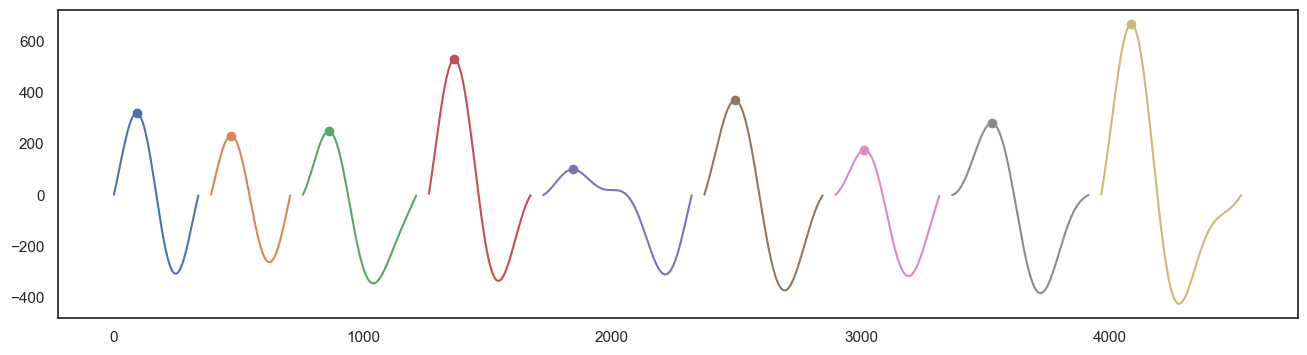

In [19]:
# Plot some exmaples of good cycles
cycles_to_plot = all_metrics['index'][11:20]
plt.figure(figsize=(16,4))
start = 0
for ii in cycles_to_plot:
  inds = cycles.get_inds_of_cycle(ii)
  cycle = nrem_filtered_data[inds]
  row = all_metrics[all_metrics['index'] == ii]
  xinds = np.arange(len(inds)) + start
  plt.plot(xinds, cycle)
  plt.scatter(row['peak_position']+start, row['peak_values'])

  start += len(inds)+50

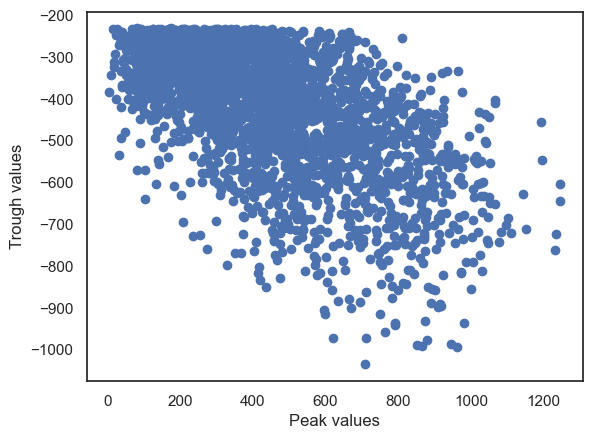

In [20]:
# Plot peak vs trough values

# fig = px.density_contour(metrics, x="peak_values", y="trough_values", marginal_x="histogram", marginal_y="histogram")
# fig.show()

plt.scatter(all_metrics['peak_values'], all_metrics['trough_values'])
plt.xlabel('Peak values')
plt.ylabel('Trough values');

# Phase-aligned cycles

In [21]:
all_waveforms, _ = emd.cycles.phase_align(IP, nrem_filtered_data,
                                                            cycles=all_cycles.iterate(through='subset'), npoints=100)
all_waveforms.shape

 Checking phase_align inputs - trimming singleton from input 'ip'


(100, 2795)

# PCA Analysis of IF

(-5.0, 5.0)

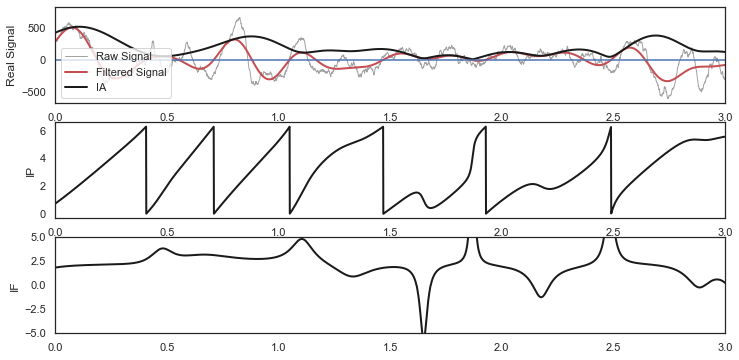

In [38]:
# Plot IA, IP, IF for a particular cycle (n sec window)

start = fs*50 # Start position for signal
length = 8

t = np.arange(fs*length) / fs
plt.figure(figsize=(12,6))
plt.subplot(3,1,1)
plt.plot(t,nrem_data[start:start+fs*length], 'k', label='Raw Signal', alpha=0.4, lw=1)
plt.plot(t,nrem_filtered_data[start:start+fs*length], 'r', label='Filtered Signal', lw=2)
plt.plot(t,IA[start:start+fs*length], 'k', label='IA', lw=2)
plt.ylabel('Real Signal')
plt.axhline(0)
plt.xlim((0, 3))
plt.legend();

plt.subplot(3,1,2)
plt.plot(t,IP[start:start+fs*length], 'k', label='IP', lw=2)
plt.ylabel('IP')
plt.xlim((0, 3))

plt.subplot(3,1,3)
plt.plot(t,IF[start:start+fs*length], 'k', label='IP', lw=2)
plt.ylabel('IF')
plt.xlim((0, 3))
plt.ylim((-5, 5))

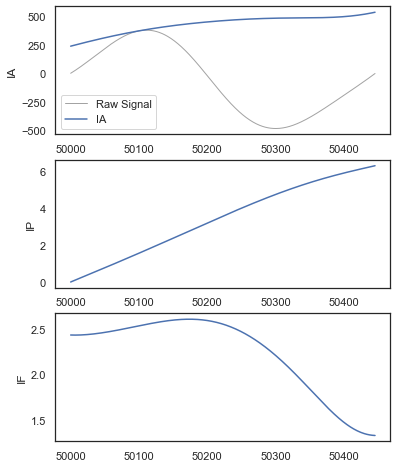

In [39]:
# Plot IA, IP, IF for a particular cycle

cycle_to_plot = 600

inds = cycles.get_inds_of_cycle(all_metrics['index'][cycle_to_plot])

plt.figure(figsize=(6,8))
plt.subplot(3,1,1)
cycle = IA[inds]
plt.plot(np.arange(len(inds)) + start,nrem_filtered_data[inds], 'k', label='Raw Signal', alpha=0.4, lw=1);
plt.plot(np.arange(len(inds)) + start, cycle, label='IA');
plt.legend()
plt.ylabel('IA')

plt.subplot(3,1,2)
cycle = IP[inds]
plt.plot(np.arange(len(inds)) + start, cycle);
plt.ylabel('IP')

plt.subplot(3,1,3)
cycle = IF[inds]
plt.plot(np.arange(len(inds)) + start, cycle);
plt.ylabel('IF');

In [35]:
pa, phasex = emd.cycles.phase_align(IP, IF, all_cycles.iterate(through='subset'))

 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'x'


In [36]:
phase_aligned_ifs = pa.T

pca_pa_waveforms = PCA(n_components=5)
pca_pa_waveforms.fit(phase_aligned_ifs)
phase_aligned_components = pd.DataFrame(pca_pa_waveforms.transform(phase_aligned_ifs))
phase_aligned_components.columns = [f'PC-{i}' for i in range(1,6)]

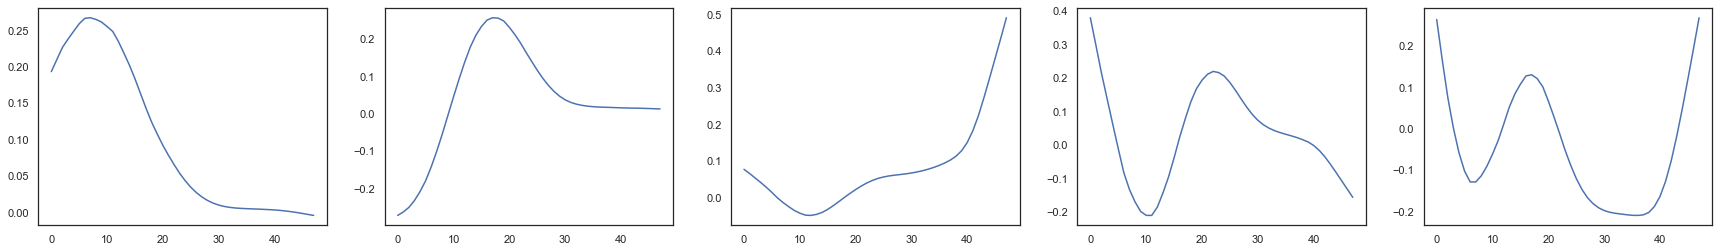

In [37]:
plt.figure(figsize=(30, 4))

for i in range(5):
    plt.subplot(1, len(pca_pa_waveforms.components_), i+1)
    pc = pca_pa_waveforms.components_[i]
    plt.plot(pc, label='PC')

In [38]:
def projection(pca, projection_score=0):
    pc_proj = np.zeros((pca_pa_waveforms.mean_.shape[0], 5))
    pc_proj.shape
    for ii in range(5):
        sc = np.zeros(5)
        sc[ii] = projection_score
        pc_proj[:, ii] = pca_pa_waveforms.inverse_transform(sc)
    return pc_proj

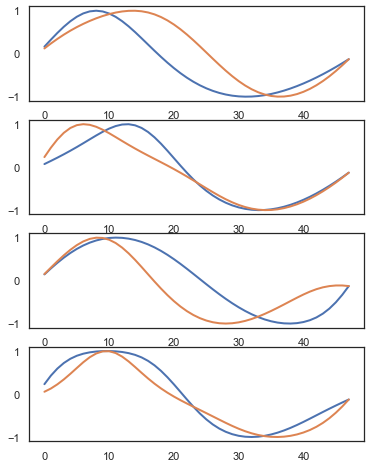

In [39]:
pc_proj = np.zeros((48, 2, 5))
val = 5  # PC-score to project
for ii in range(5):
    sc = np.zeros((2, 5))
    sc[0, ii] = val
    sc[1, ii] = -val
    pc_proj[:, :, ii] = pca_pa_waveforms.inverse_transform(sc).T

plt.figure(figsize=(6,8))
plt.subplot(4,1,1)
sr = pc_proj[:, 0, 0].mean() * 49
phase = emd.spectra.phase_from_freq(pc_proj[:, 0, 0], sr, phase_start=0)
plt.plot(np.sin(phase), linewidth=2)

sr = pc_proj[:, 1, 0].mean() * 49
phase = emd.spectra.phase_from_freq(pc_proj[:, 1, 0], sr, phase_start=0)
plt.plot(np.sin(phase), linewidth=2)

plt.subplot(4,1,2)
sr = pc_proj[:, 0, 1].mean() * 49
phase = emd.spectra.phase_from_freq(pc_proj[:, 0, 1], sr, phase_start=0)
plt.plot(np.sin(phase), linewidth=2)

sr = pc_proj[:, 1, 1].mean() * 49
phase = emd.spectra.phase_from_freq(pc_proj[:, 1, 1], sr, phase_start=0)
plt.plot(np.sin(phase), linewidth=2)

plt.subplot(4,1,3)
sr = pc_proj[:, 0, 2].mean() * 49
phase = emd.spectra.phase_from_freq(pc_proj[:, 0, 2], sr, phase_start=0)
plt.plot(np.sin(phase), linewidth=2)

sr = pc_proj[:, 1, 2].mean() * 49
phase = emd.spectra.phase_from_freq(pc_proj[:, 1, 2], sr, phase_start=0)
plt.plot(np.sin(phase), linewidth=2)

plt.subplot(4,1,4)
sr = pc_proj[:, 0, 3].mean() * 49
phase = emd.spectra.phase_from_freq(pc_proj[:, 0, 3], sr, phase_start=0)
plt.plot(np.sin(phase), linewidth=2)

sr = pc_proj[:, 1, 3].mean() * 49
phase = emd.spectra.phase_from_freq(pc_proj[:, 1, 3], sr, phase_start=0)
plt.plot(np.sin(phase), linewidth=2)

In [40]:
pa_waveform, _ = emd.cycles.phase_align(IP, IF, all_cycles.iterate(through='subset'))
norm_waveform, sine = emd.cycles.normalised_waveform(pa_waveform)

 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'x'


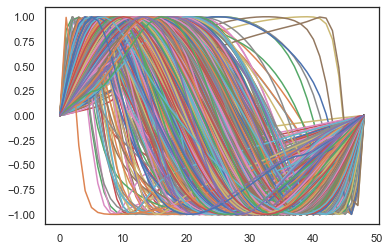

In [41]:
plt.plot(norm_waveform);

# Load cycles for 13-CN Post-Trials

In [22]:
path_to_data = './data_13_CN/'
data_file = 'Cleaned_Trial1_PFC_100_CH63_0.continuous.mat'
states_file = '2019-05-13_11-24-48_post_trial1-states.mat'
pfc_data1, sleep_scoring1 = load_mat_data(path_to_data, data_file, states_file)

data_file = 'Cleaned_Trial2_PFC_100_CH63_0.continuous.mat'
states_file = '2019-05-13_12-15-25_post_trial2-states.mat'
pfc_data2, sleep_scoring2 = load_mat_data(path_to_data, data_file, states_file)

data_file = 'Cleaned_Trial3_PFC_100_CH63_0.continuous.mat'
states_file = '2019-05-13_13-05-57_post_trial3-states.mat'
pfc_data3, sleep_scoring3 = load_mat_data(path_to_data, data_file, states_file)

data_file = 'Cleaned_Trial4_PFC_100_CH63_0.continuous.mat'
states_file = '2019-05-13_13-56-29_post_trial4-states.mat'
pfc_data4, sleep_scoring4 = load_mat_data(path_to_data, data_file, states_file)

data_file = 'Cleaned_Trial5_PFC_100_CH63_0.continuous.mat'
states_file = '2019-05-13_14-53-54_post_trial5-states.mat'
pfc_data5, sleep_scoring5 = load_mat_data(path_to_data, data_file, states_file)

nrem_epochs1 = np.array(get_all_NREM_epochs(sleep_scoring1))
nrem_epochs2 = np.array(get_all_NREM_epochs(sleep_scoring2))
nrem_epochs3 = np.array(get_all_NREM_epochs(sleep_scoring3))
nrem_epochs4 = np.array(get_all_NREM_epochs(sleep_scoring4))
nrem_epochs5 = np.array(get_all_NREM_epochs(sleep_scoring5))

In [23]:
len(pfc_data1)/len(sleep_scoring1)

2500.155844155844

In [24]:
fs = 2500
nrem_filtered_data1, nrem_data1 = get_nrem_filtered(pfc_data1, nrem_epochs1, fs=fs)
nrem_filtered_data2, nrem_data2 = get_nrem_filtered(pfc_data2, nrem_epochs2, fs=fs)
nrem_filtered_data3, nrem_data3 = get_nrem_filtered(pfc_data3, nrem_epochs3, fs=fs)
nrem_filtered_data4, nrem_data4 = get_nrem_filtered(pfc_data4, nrem_epochs4, fs=fs)
nrem_filtered_data5, nrem_data5 = get_nrem_filtered(pfc_data5, nrem_epochs5, fs=fs)

C:\anaconda3\Lib\site-packages\neurodsp\filt\utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))


In [25]:
# Extract Instantaneous phase (IP), frequency and amplitude (from Hilbert Transform)
IP1, IF1, IA1 = emd.spectra.frequency_transform(nrem_filtered_data1, fs, 'hilbert')
IP2, IF2, IA2 = emd.spectra.frequency_transform(nrem_filtered_data2, fs, 'hilbert')
IP3, IF3, IA3 = emd.spectra.frequency_transform(nrem_filtered_data3, fs, 'hilbert')
IP4, IF4, IA4 = emd.spectra.frequency_transform(nrem_filtered_data4, fs, 'hilbert')
IP5, IF5, IA5 = emd.spectra.frequency_transform(nrem_filtered_data5, fs, 'hilbert')

# Get cycles using IP
C1 = emd.cycles.Cycles(IP1)
C2 = emd.cycles.Cycles(IP2)
C3 = emd.cycles.Cycles(IP3)
C4 = emd.cycles.Cycles(IP4)
C5 = emd.cycles.Cycles(IP5)

 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'


In [26]:
cycles1 = get_cycles_with_metrics(C1, nrem_filtered_data1, IA1, IF1)
cycles2 = get_cycles_with_metrics(C2, nrem_filtered_data2, IA2, IF2)
cycles3 = get_cycles_with_metrics(C3, nrem_filtered_data3, IA3, IF3)
cycles4 = get_cycles_with_metrics(C4, nrem_filtered_data4, IA4, IF4)
cycles5 = get_cycles_with_metrics(C5, nrem_filtered_data5, IA5, IF5)

# ===================================

In [144]:
amp_thresh = np.percentile(IA5, 40)
peak_thresh5 = np.percentile(metrics5['peak_values'], 0)
trough_thresh5 = np.percentile(metrics5['trough_values'], 100)

# all_cycles5
# cycles5

conditions5 = ['is_good==1',
#               f'max_amp>{amp_thresh}',
              f'duration_samples<{lo_freq_duration}',
              f'duration_samples>{hi_freq_duration}',
              f'peak_values>={peak_thresh5}',
              f'trough_values<={trough_thresh5}'] # Depolarization

In [47]:
print(trough_thresh5)
all_cycles5 = get_cycles_with_conditions(cycles5, conditions5)
metrics_temp = all_cycles5.get_metric_dataframe(subset=True)
metrics_temp

0.7152952919833551


,index,is_good,duration_samples,peak2trough,asc2desc,max_amp,trough_values,peak_values,mean_if,max_if,range_if,trough_position,peak_position,chain_ind
0,5,1,1002,0.350563,0.461135,183.173115,-162.066544,66.345723,2.501669,29.264732,27.860012,713,173,0
1,6,1,1023,0.401217,0.542127,203.085972,-168.744238,124.810160,2.444147,4.111137,2.339805,676,208,0
2,7,1,1097,0.393880,0.418588,161.297885,-160.898757,58.472170,2.279329,4.592387,3.251395,840,202,0
3,9,1,761,0.338504,0.468134,120.707973,-119.893708,33.507794,3.283371,7.154532,5.002390,532,128,1
4,10,1,805,0.358449,0.505202,216.816269,-211.768123,72.734931,3.106762,5.226231,2.964700,549,151,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4514,7525,1,1348,0.572967,0.627578,417.739187,-383.157619,301.925568,1.854933,2.227678,0.984586,1026,524,1629
4515,7528,1,833,0.614014,0.514337,188.520202,-28.583676,150.846321,3.002087,8.033007,7.002123,635,230,1630
4516,7530,1,1180,0.885735,0.537690,197.197450,-7.637199,164.279539,2.118677,471.284391,470.877061,1116,570,1631
4517,7531,1,1418,0.430914,0.663163,268.838748,-209.676530,232.663233,1.762905,2.277169,1.209228,852,374,1631


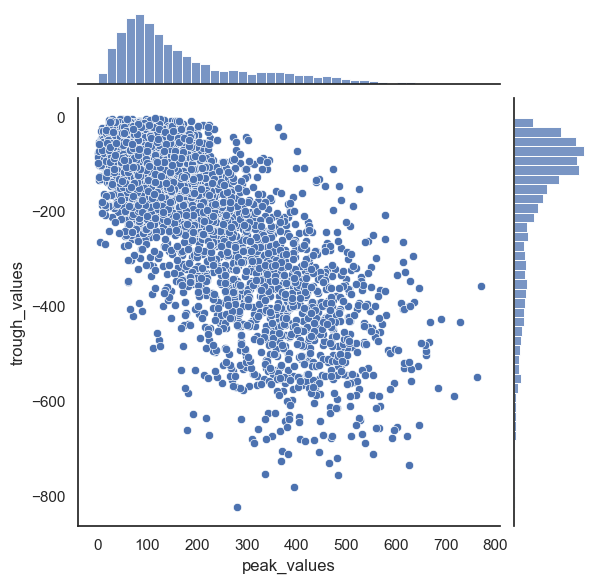

In [48]:
sns.jointplot(x=metrics_temp['peak_values'], y=metrics_temp['trough_values'], kind='scatter')

In [49]:
all_waveforms5, _ = emd.cycles.phase_align(IP5, nrem_filtered_data5,
                                                            cycles=all_cycles5.iterate(through='subset'), npoints=50)

 Checking phase_align inputs - trimming singleton from input 'ip'


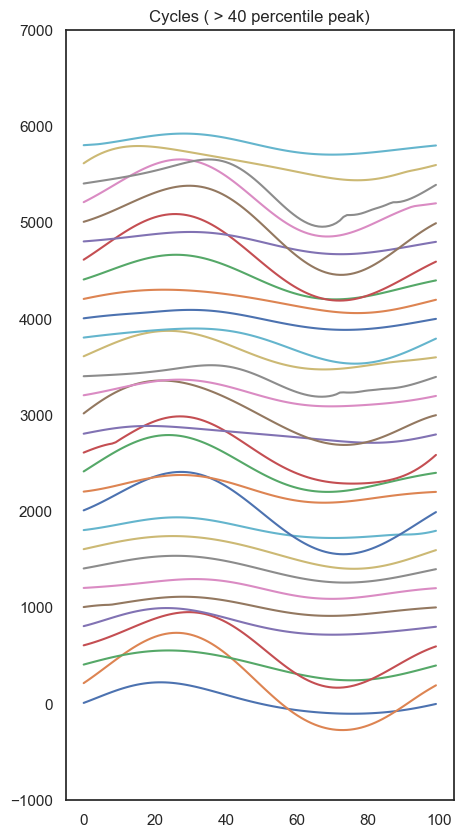

In [216]:
waveforms = all_waveforms5

def plot_waveforms(waveforms, title=""):
    plt.figure(figsize=(5,10), facecolor='white')
    plt.title(title)
    # plt.yticks([])
    start = 0
    cycles_to_plot = np.random.randint(1, waveforms.shape[1], 30)
    for i in cycles_to_plot:
        plt.plot(waveforms[:,i]+start)
        start += 200
    plt.ylim((-1000, 7000))

plot_waveforms(waveforms, 'Cycles ( > 40 percentile peak)')

# =======================================

In [533]:
metrics1 = cycles1.get_metric_dataframe()
metrics2 = cycles2.get_metric_dataframe()
metrics3 = cycles3.get_metric_dataframe()
metrics4 = cycles4.get_metric_dataframe()
metrics5 = cycles5.get_metric_dataframe()

trough = 60
peak = 40
# amp_thresh = np.percentile(IA, 25) # 25th percentile of the amplitude
peak_thresh1 = np.percentile(metrics1['peak_values'], peak)
trough_thresh1 = np.percentile(metrics1['trough_values'], trough)
peak_thresh2 = np.percentile(metrics2['peak_values'], peak)
trough_thresh2 = np.percentile(metrics2['trough_values'], trough)
peak_thresh3 = np.percentile(metrics3['peak_values'], peak)
trough_thresh3 = np.percentile(metrics3['trough_values'], trough)
peak_thresh4 = np.percentile(metrics4['peak_values'], peak)
trough_thresh4 = np.percentile(metrics4['trough_values'], trough)
peak_thresh5 = np.percentile(metrics5['peak_values'], peak)
trough_thresh5 = np.percentile(metrics5['trough_values'], trough)

lo_freq_duration = fs/0.1
hi_freq_duration = fs/4

In [534]:
conditions1 = ['is_good==1',
              # f'max_amp>{amp_thresh}',
              f'duration_samples<{lo_freq_duration}',
              f'duration_samples>{hi_freq_duration}',
              f'peak_values>={peak_thresh1}',
              f'trough_values<={trough_thresh1}']
conditions2 = ['is_good==1',
              # f'max_amp>{amp_thresh}',
              f'duration_samples<{lo_freq_duration}',
              f'duration_samples>{hi_freq_duration}',
              f'peak_values>={peak_thresh2}',
              f'trough_values<={trough_thresh2}']
conditions3 = ['is_good==1',
              # f'max_amp>{amp_thresh}',
              f'duration_samples<{lo_freq_duration}',
              f'duration_samples>{hi_freq_duration}',
              f'peak_values>={peak_thresh3}',
              f'trough_values<={trough_thresh3}']
conditions4 = ['is_good==1',
              # f'max_amp>{amp_thresh}',
              f'duration_samples<{lo_freq_duration}',
              f'duration_samples>{hi_freq_duration}',
              f'peak_values>={peak_thresh4}',
              f'trough_values<={trough_thresh4}']
conditions5 = ['is_good==1',
              # f'max_amp>{amp_thresh}',
              f'duration_samples<{lo_freq_duration}',
              f'duration_samples>{hi_freq_duration}',
              f'peak_values>={peak_thresh5}',
              f'trough_values<={trough_thresh5}']

all_cycles1 = get_cycles_with_conditions(cycles1, conditions1)
all_cycles2 = get_cycles_with_conditions(cycles2, conditions2)
all_cycles3 = get_cycles_with_conditions(cycles3, conditions3)
all_cycles4 = get_cycles_with_conditions(cycles4, conditions4)
all_cycles5 = get_cycles_with_conditions(cycles5, conditions5)

In [540]:
all_waveforms1, _ = emd.cycles.phase_align(IP1, nrem_filtered_data1,
                                                            cycles=all_cycles1.iterate(through='subset'), npoints=100)
all_waveforms2, _ = emd.cycles.phase_align(IP2, nrem_filtered_data2,
                                                            cycles=all_cycles2.iterate(through='subset'), npoints=100)
all_waveforms3, _ = emd.cycles.phase_align(IP3, nrem_filtered_data3,
                                                            cycles=all_cycles3.iterate(through='subset'), npoints=100)
all_waveforms4, _ = emd.cycles.phase_align(IP4, nrem_filtered_data4,
                                                            cycles=all_cycles4.iterate(through='subset'), npoints=100)
all_waveforms5, _ = emd.cycles.phase_align(IP5, nrem_filtered_data5,
                                                            cycles=all_cycles5.iterate(through='subset'), npoints=100)

 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'ip'


In [535]:
all_metrics1 = all_cycles1.get_metric_dataframe(subset=True)
all_metrics2 = all_cycles2.get_metric_dataframe(subset=True)
all_metrics3 = all_cycles3.get_metric_dataframe(subset=True)
all_metrics4 = all_cycles4.get_metric_dataframe(subset=True)
all_metrics5 = all_cycles5.get_metric_dataframe(subset=True)

# PCA

In [541]:
# pca_df = all_metrics[['duration_samples', 'peak2trough', 'asc2desc', 'max_amp', 'peak_values', 'trough_values', 'mean_if', 'max_if', 'range_if']]
# # pca_df = pd.concat([pca_df, pd.DataFrame(all_waveforms.T)], axis=1)
# pca_df.columns = pca_df.columns.astype('str')

In [542]:
pca_df1 = all_metrics1[['index', 'duration_samples', 'peak2trough', 'asc2desc', 'max_amp', 'peak_values', 'trough_values', 'mean_if', 'max_if', 'range_if']]
pca_df1 = pd.concat([pca_df1, pd.DataFrame(all_waveforms1.T)], axis=1)
pca_df1['post-trial'] = 1

pca_df2 = all_metrics2[['index', 'duration_samples', 'peak2trough', 'asc2desc', 'max_amp', 'peak_values', 'trough_values', 'mean_if', 'max_if', 'range_if']]
pca_df2 = pd.concat([pca_df2, pd.DataFrame(all_waveforms2.T)], axis=1)
pca_df2['post-trial'] = 2

pca_df3 = all_metrics3[['index', 'duration_samples', 'peak2trough', 'asc2desc', 'max_amp', 'peak_values', 'trough_values', 'mean_if', 'max_if', 'range_if']]
pca_df3 = pd.concat([pca_df3, pd.DataFrame(all_waveforms3.T)], axis=1)
pca_df3['post-trial'] = 3

pca_df4 = all_metrics4[['index', 'duration_samples', 'peak2trough', 'asc2desc', 'max_amp', 'peak_values', 'trough_values', 'mean_if', 'max_if', 'range_if']]
pca_df4 = pd.concat([pca_df4, pd.DataFrame(all_waveforms4.T)], axis=1)
pca_df4['post-trial'] = 4

pca_df5 = all_metrics5[['index', 'duration_samples', 'peak2trough', 'asc2desc', 'max_amp', 'peak_values', 'trough_values', 'mean_if', 'max_if', 'range_if']]
pca_df5 = pd.concat([pca_df5, pd.DataFrame(all_waveforms5.T)], axis=1)
pca_df5['post-trial'] = 5

In [543]:
pca_df_with_waveforms = pd.concat([pca_df1, pca_df2, pca_df3, pca_df4, pca_df5])
pca_df_with_waveforms.columns = pca_df_with_waveforms.columns.astype('str')

In [544]:
pca_df_with_waveforms

,index,duration_samples,peak2trough,asc2desc,max_amp,peak_values,trough_values,mean_if,max_if,range_if,...,91,92,93,94,95,96,97,98,99,post-trial
0,3,866,0.374093,0.555473,213.111977,121.632195,-193.448410,2.885489,5.768119,4.584288,...,-100.276311,-87.713465,-74.989333,-62.264064,-49.705813,-37.487838,-25.785398,-14.780495,-4.662556,1
1,7,1185,0.528976,0.493500,280.085710,220.697613,-109.954799,2.110257,2.674485,1.001667,...,-53.160881,-46.610427,-39.981717,-33.345187,-26.773784,-20.342769,-14.126059,-8.198136,-2.629067,1
2,13,865,0.632630,0.536450,265.602936,265.601733,-119.928620,2.891985,5.253642,3.460292,...,-44.572426,-39.518603,-34.406473,-29.240679,-24.023595,-18.759181,-13.450247,-8.099012,-2.708716,1
3,14,1096,0.329381,0.565664,212.029051,127.822182,-211.898903,2.279391,5.174361,4.056746,...,-98.003122,-86.364747,-74.582778,-62.732776,-50.894544,-39.149121,-27.579748,-16.272612,-5.317071,1
4,16,745,0.528327,0.526504,164.068451,145.122682,-148.002151,3.351703,4.130252,1.071054,...,-64.752157,-57.284601,-49.719182,-42.083503,-34.404904,-26.709736,-19.023118,-11.369211,-3.771203,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2524,7515,1082,0.655765,0.572216,616.181864,613.071952,-263.044418,2.308145,5.880278,5.052282,...,-69.532664,-60.914238,-52.429066,-44.071393,-35.833648,-27.705910,-19.680598,-11.747531,-3.897195,5
2525,7517,711,0.510404,0.494414,427.283530,187.100250,-109.487748,3.515547,9.896120,7.872497,...,-76.985539,-69.310729,-61.031537,-52.245045,-43.058788,-33.587664,-23.954254,-14.285443,-4.710972,5
2526,7520,1052,0.448817,0.565301,424.377906,265.729892,-423.408612,2.378094,2.810883,1.165190,...,-198.721628,-174.769874,-150.566217,-126.297053,-102.150947,-78.316373,-54.979371,-32.323692,-10.524994,5
2527,7525,1348,0.572967,0.627578,417.739187,301.925568,-383.157619,1.854933,2.227678,0.984586,...,-135.882066,-117.268777,-99.078352,-81.447572,-64.507718,-48.383637,-33.192911,-19.045161,-6.042412,5


In [545]:
pca_df_combined = pca_df_with_waveforms[['duration_samples', 'peak2trough', 'asc2desc', 'max_amp', 'peak_values', 'trough_values', 'mean_if', 'max_if', 'range_if']]

In [546]:
# pca = PCA(n_components=5)
# pca.fit(pca_df)
# X = pd.DataFrame(pca.transform(pca_df))
# X.columns = [f'PC-{i}' for i in range(1,6)]
# pca_df_combined

scaled_data = StandardScaler().fit_transform(pca_df_combined)

pca_combined = PCA(n_components=5)
pca_combined.fit(scaled_data)
components_combined = pd.DataFrame(pca_combined.transform(scaled_data))
components_combined.columns = [f'PC-{i}' for i in range(1,6)]

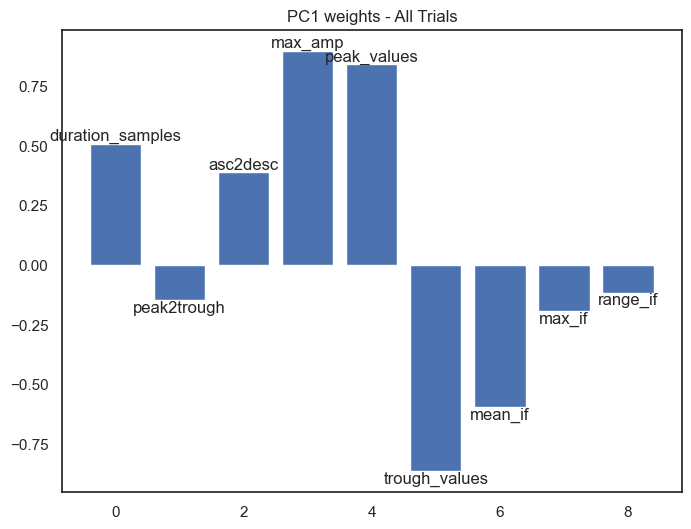

In [547]:
plt.figure(figsize=(8, 6), facecolor="white")

component = 1
pca_weights = (pca_combined.components_.T * np.sqrt(pca_combined.explained_variance_))[:, component-1]
pca_weights = pca_weights
p = plt.bar(range(len(pca_weights)), pca_weights)
plt.bar_label(p, list(pca_df_combined.columns));
plt.title(f"PC{component} weights - All Trials");

# plt.savefig(f'Component{component}-13-CN-all-trials.svg')

## K-Means Clustering

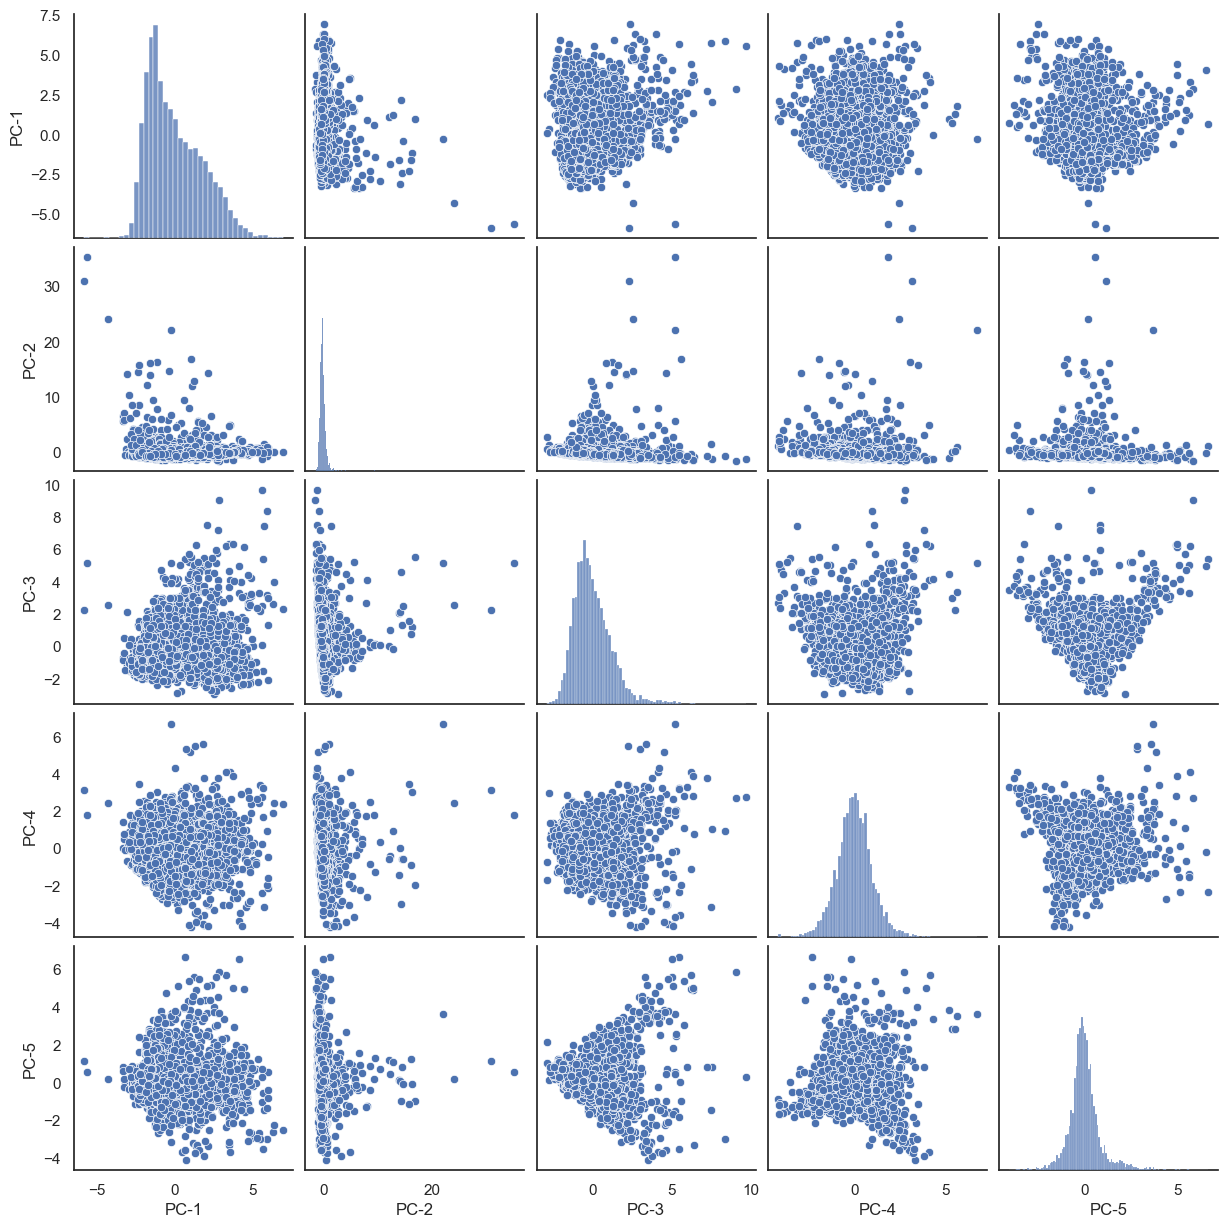

In [548]:
sns.pairplot(components_combined)

In [549]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(components_combined)

C:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



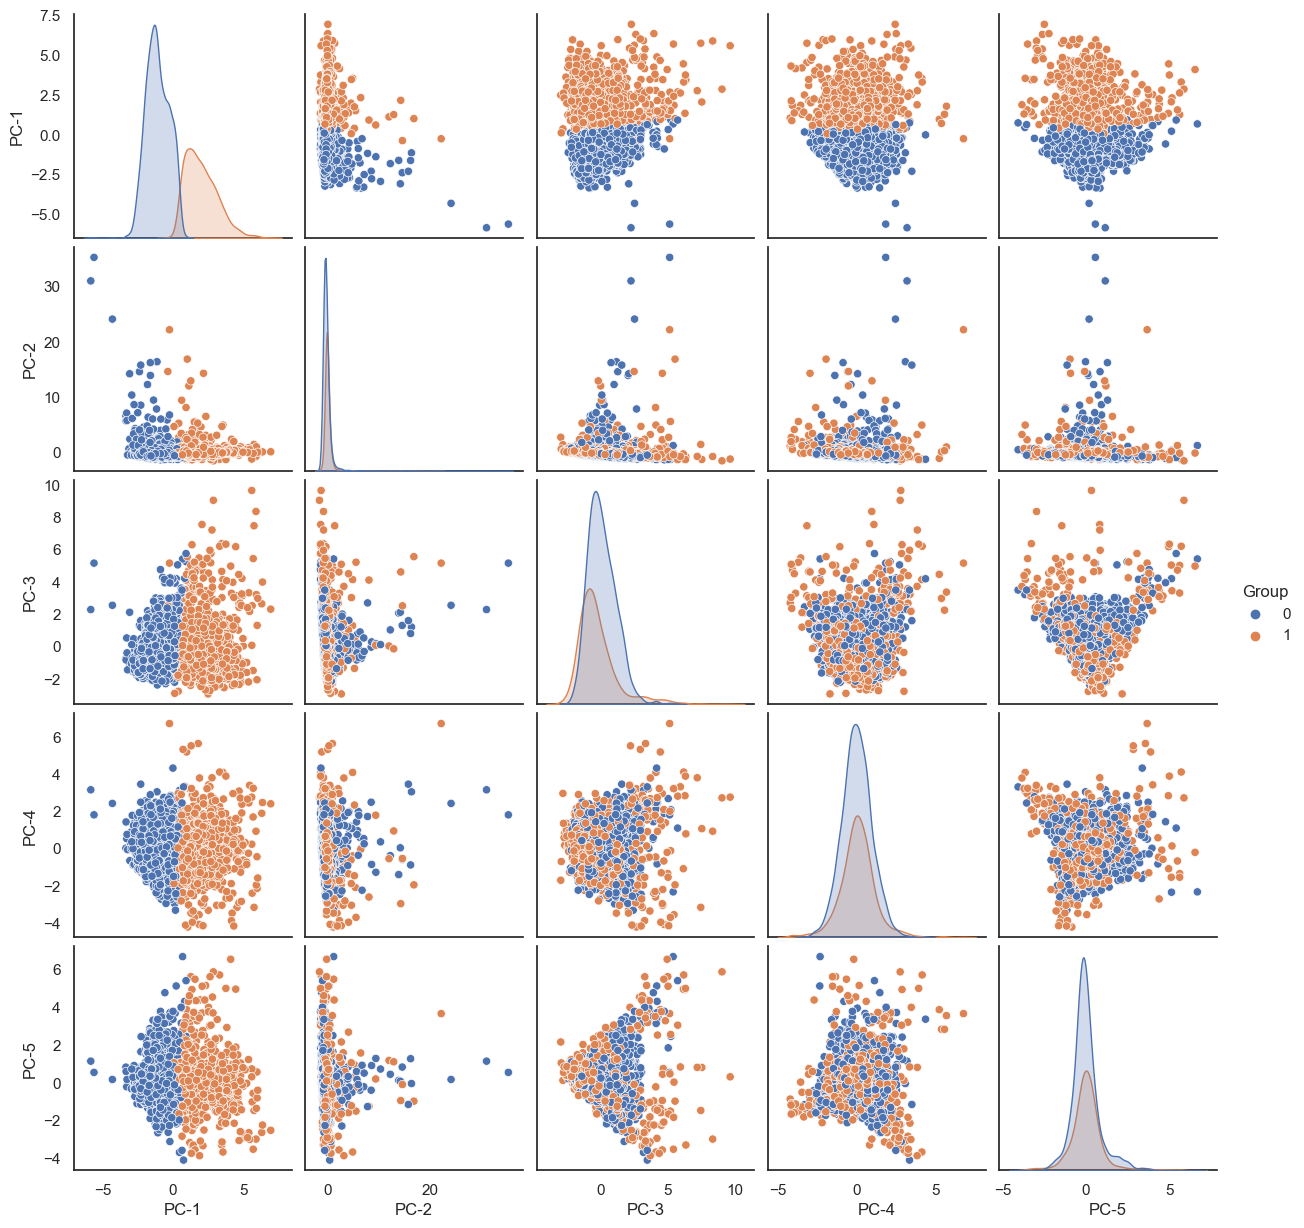

In [550]:
y_pred = kmeans.predict(components_combined)
df = pd.concat([components_combined, pd.DataFrame({"Group": y_pred})], axis=1)
sns.pairplot(df, hue='Group')

plt.savefig(f'PC-Kmeans-13-CN-{peak} {trough}.svg')

In [551]:
pca_df_with_waveforms['cluster'] = y_pred

In [552]:
cluster0_data = pca_df_with_waveforms[pca_df_with_waveforms['cluster'] == 0]
cluster1_data = pca_df_with_waveforms[pca_df_with_waveforms['cluster'] == 1]
cluster1_data

,index,duration_samples,peak2trough,asc2desc,max_amp,peak_values,trough_values,mean_if,max_if,range_if,...,92,93,94,95,96,97,98,99,post-trial,cluster
6,19,957,0.567401,0.556370,435.811031,427.750109,-211.826149,2.611521,11.132593,8.955283,...,-19.874726,-16.179598,-12.888793,-9.952256,-7.324343,-4.964434,-2.830986,-0.903731,1,1
12,38,1033,0.501025,0.556154,613.741290,506.505852,-522.604608,2.418586,2.668090,0.334218,...,-160.660398,-136.964056,-113.790358,-91.246793,-69.433733,-48.436500,-28.334420,-9.192523,1,1
16,51,1144,0.457976,0.587154,581.373842,563.313416,-425.938401,2.185676,2.397996,1.159068,...,-107.643103,-89.839821,-72.886539,-56.903468,-42.005363,-28.302575,-15.902972,-4.921158,1,1
17,54,1289,0.656063,0.668424,361.938810,307.202429,-339.029132,1.938479,2.974637,2.758899,...,-131.183374,-113.405403,-95.553957,-77.719854,-59.992186,-42.457044,-25.198403,-8.295106,1,1
22,68,929,0.493937,0.549867,486.748997,433.206634,-408.825870,2.691011,2.896910,0.271810,...,-127.443156,-108.657948,-90.271626,-72.376164,-55.056122,-38.388394,-22.441446,-7.275235,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2522,7510,821,0.416785,0.521971,472.058542,327.381167,-472.014087,3.043531,3.926370,1.555497,...,-186.902447,-160.834407,-134.804430,-108.991144,-83.568700,-58.704244,-34.556642,-11.274237,5,1
2524,7515,1082,0.655765,0.572216,616.181864,613.071952,-263.044418,2.308145,5.880278,5.052282,...,-60.914238,-52.429066,-44.071393,-35.833648,-27.705910,-19.680598,-11.747531,-3.897195,5,1
2526,7520,1052,0.448817,0.565301,424.377906,265.729892,-423.408612,2.378094,2.810883,1.165190,...,-174.769874,-150.566217,-126.297053,-102.150947,-78.316373,-54.979371,-32.323692,-10.524994,5,1
2527,7525,1348,0.572967,0.627578,417.739187,301.925568,-383.157619,1.854933,2.227678,0.984586,...,-117.268777,-99.078352,-81.447572,-64.507718,-48.383637,-33.192911,-19.045161,-6.042412,5,1


(0.0, 1500.0)

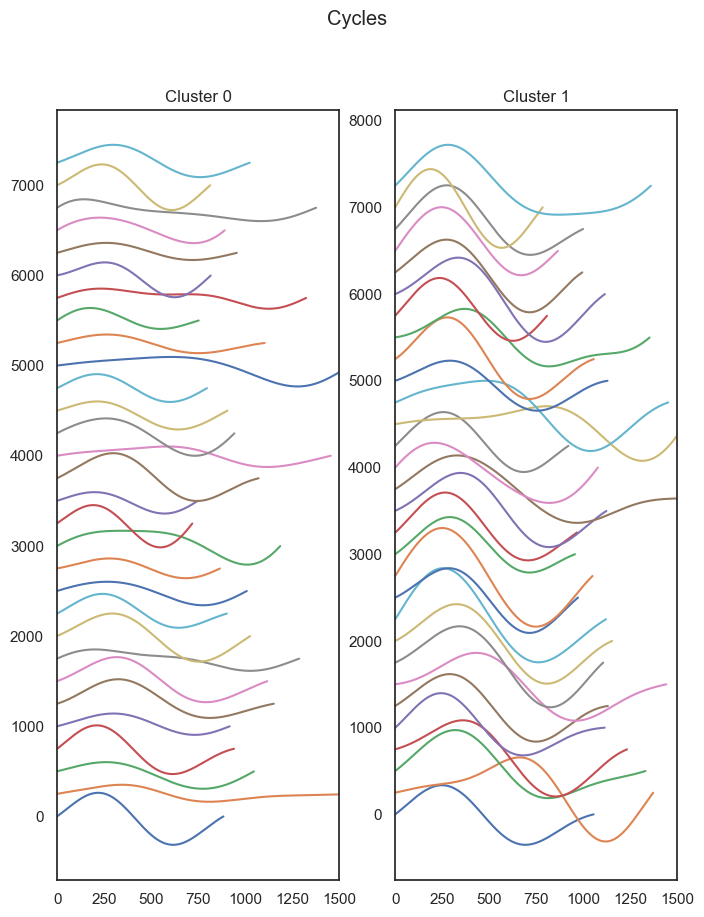

In [553]:
plt.figure(figsize=(8,10))
plt.suptitle("Cycles")

plt.subplot(1, 2, 1)
plt.title('Cluster 0')

start = 0
cluster0_sample = cluster0_data.sample(n=30)
for index, row in cluster0_sample.iterrows():
    if row['post-trial'] == 1:
        inds = all_cycles1.get_inds_of_cycle(row['index'])
        cycle = nrem_filtered_data1[inds]
    if row['post-trial'] == 2:
        inds = all_cycles2.get_inds_of_cycle(row['index'])
        cycle = nrem_filtered_data2[inds]
    if row['post-trial'] == 3:
        inds = all_cycles3.get_inds_of_cycle(row['index'])
        cycle = nrem_filtered_data3[inds]
    if row['post-trial'] == 4:
        inds = all_cycles4.get_inds_of_cycle(row['index'])
        cycle = nrem_filtered_data4[inds]
    if row['post-trial'] == 5:
        inds = all_cycles5.get_inds_of_cycle(row['index'])
        cycle = nrem_filtered_data5[inds]
    plt.plot(cycle+start)
    start += 250
plt.xlim((0, 1500))


plt.subplot(1, 2, 2)
plt.title('Cluster 1')

start = 0
cluster1_sample = cluster1_data.sample(n=30)
for index, row in cluster1_sample.iterrows():
    if row['post-trial'] == 1:
        inds = all_cycles1.get_inds_of_cycle(row['index'])
        cycle = nrem_filtered_data1[inds]
    if row['post-trial'] == 2:
        inds = all_cycles2.get_inds_of_cycle(row['index'])
        cycle = nrem_filtered_data2[inds]
    if row['post-trial'] == 3:
        inds = all_cycles3.get_inds_of_cycle(row['index'])
        cycle = nrem_filtered_data3[inds]
    if row['post-trial'] == 4:
        inds = all_cycles4.get_inds_of_cycle(row['index'])
        cycle = nrem_filtered_data4[inds]
    if row['post-trial'] == 5:
        inds = all_cycles5.get_inds_of_cycle(row['index'])
        cycle = nrem_filtered_data5[inds]
    plt.plot(cycle+start)
    start += 250
plt.xlim((0, 1500))

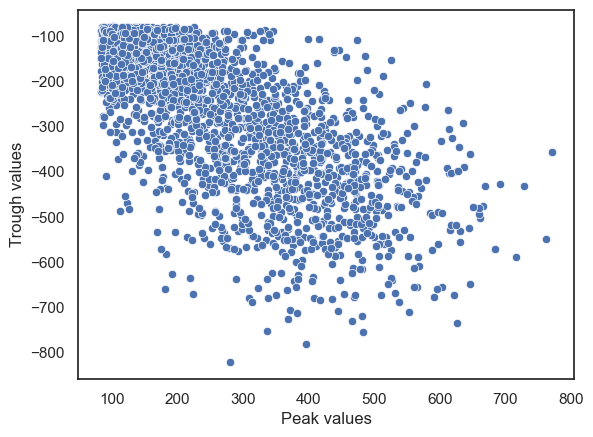

In [555]:
sns.scatterplot(x=all_metrics5['peak_values'], y=all_metrics5['trough_values'])
plt.xlabel('Peak values')
plt.ylabel('Trough values');

# Extras

In [556]:
import umap.umap_ as umap

In [557]:
scaled_data = StandardScaler().fit_transform(pca_df_combined)

In [558]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3)

In [559]:
embedding = reducer.fit_transform(scaled_data)

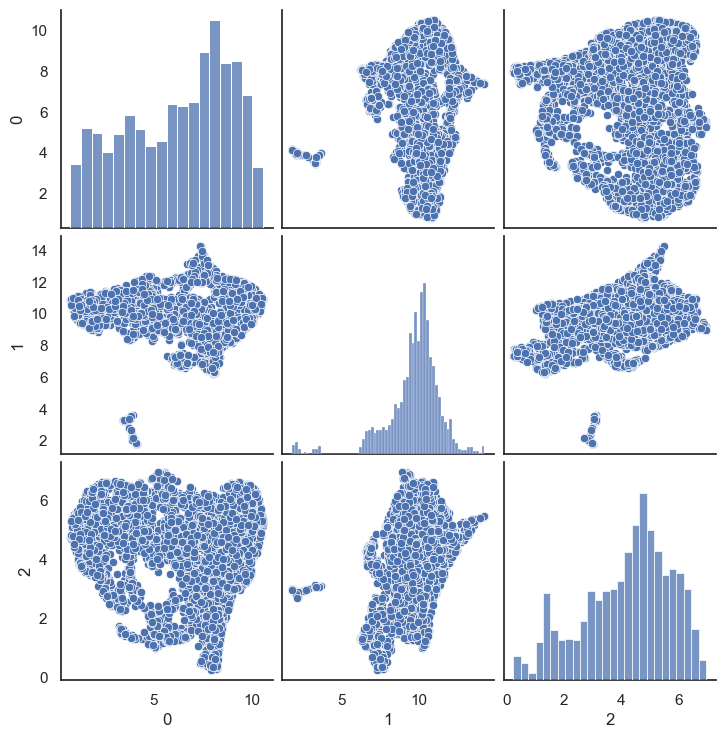

In [560]:
sns.pairplot(pd.DataFrame(embedding))